In [2]:
from pathlib import Path
import configparser
from psycopg2 import connect
import struct
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import geopandas as gpd

CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg'))) #Creates a path to your db.cfg file
dbset = CONFIG['SQLALCHEMY']

with connect(**dbset) as con:
    basemap_query = '''select gis.geopandas_transform(ST_union(geom)) as geom from gis.neighbourhood'''
    basemap = gpd.GeoDataFrame.from_postgis(basemap_query, con, geom_col='geom')
    basemap = basemap.to_crs('epsg:26917')

/data/jupyterhub/.venv/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [3]:
sql = '''SELECT hr, bin_length, count, legend
FROM gwolofs.congestion_bin_length_explore'''

try:
    with connect(**dbset) as con:
        df = pd.read_sql(sql, con)
except Exception as e:
    print("Error connecting to the database:", e)
    exit()

/tmp/ipykernel_2029777/423225491.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con)


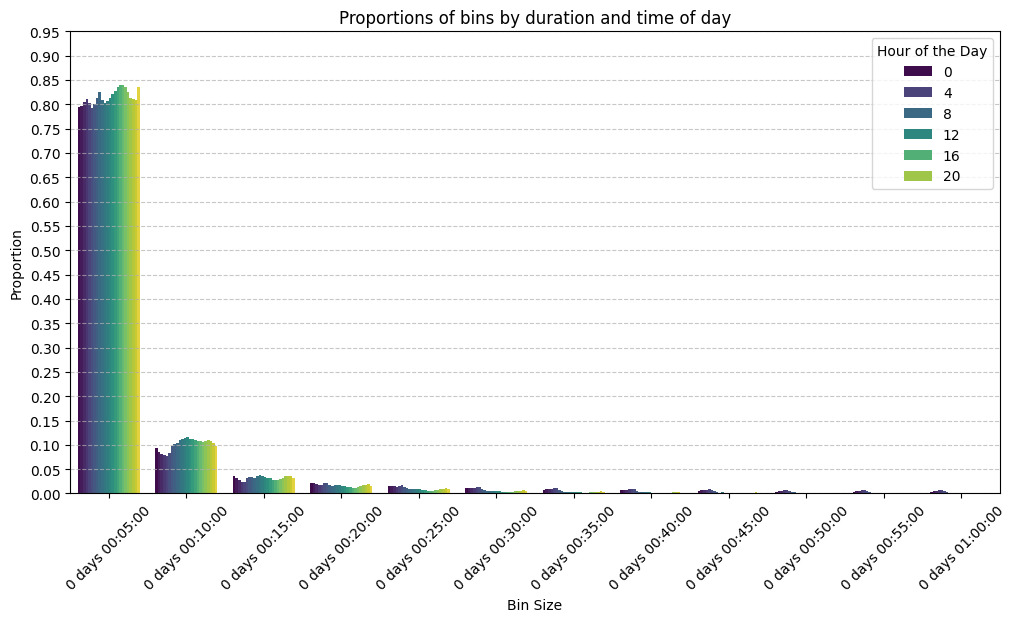

In [5]:
# Convert bin_length to string for categorical x-axis
df['bin_length'] = df['bin_length'].astype(str)

# Compute proportions within each bin_size group
df['proportion'] = df.groupby('hr')['count'].transform(lambda x: x / x.sum())

# Plot multi-bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=df['bin_length'], y=df['proportion'], hue=df['hr'], palette='viridis')
plt.xlabel('Bin Size')
plt.ylabel('Proportion')
plt.title('Proportions of bins by duration and time of day')
plt.yticks([i * 0.01 for i in range(0, 100, 5)])
plt.xticks(rotation=45)
plt.legend(title='Hour of the Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
#note, higher proportion of longer bins before ~8am

In [5]:
sql = '''SELECT
    CASE
        WHEN time_grp = '[00:00:00,24:00:00)' THEN '24hr'
        WHEN (upper(time_grp) - lower(time_grp)) = '01:00:00'::interval THEN '1hr'
        ELSE 'Periods'
    END AS legend,
    lower(bin_range)::time AS bin_start,
    upper(bin_range)::time AS bin_end
FROM gwolofs.congestion_raw_segments
WHERE dt >= '2024-12-01' AND dt < '2024-12-02' AND segment_id = 2511
ORDER BY 1, 2'''

try:
    with connect(**dbset) as con:
        df = pd.read_sql(sql, con)
        # Convert time columns to datetime
except Exception as e:
    print("Error connecting to the database:", e)
    exit()

# Convert time columns to seconds since midnight
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

df['bin_start'] = df['bin_start'].apply(time_to_seconds)
df['bin_end'] = df['bin_end'].apply(time_to_seconds)
df['duration'] = df['bin_end'] - df['bin_start']


/tmp/ipykernel_1286164/1604576776.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con)


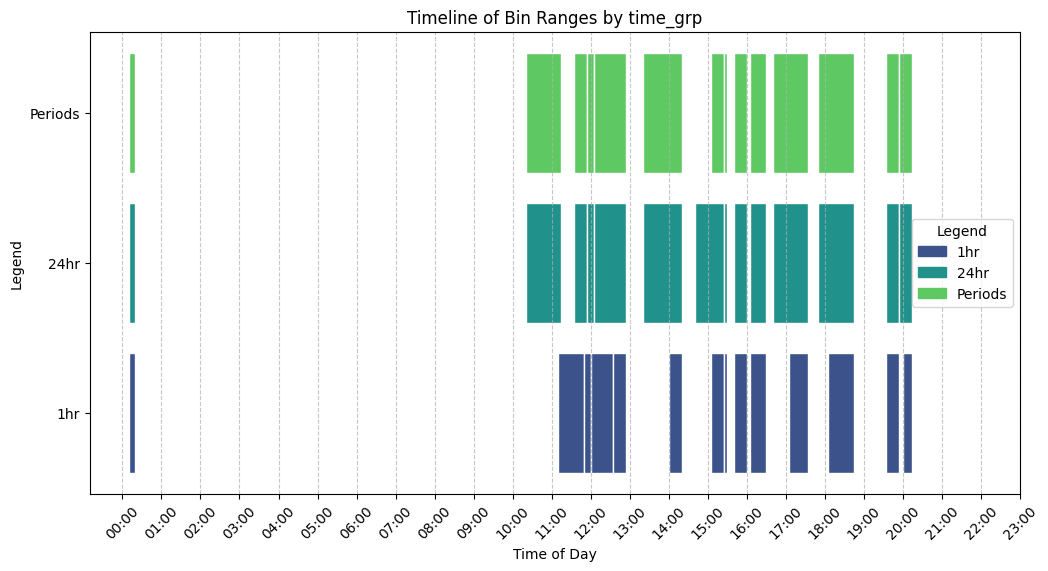

In [6]:
# Assign numeric values for y-axis based on legend
y_labels = df['legend'].unique()
y_mapping = {label: i for i, label in enumerate(y_labels)}
df['y_pos'] = df['legend'].map(y_mapping)

# Define color mapping
palette = sns.color_palette('viridis', n_colors=len(y_labels))
legend_colors = {label: palette[i] for i, label in enumerate(y_labels)}

# Plot timeline graph using broken_barh
fig, ax = plt.subplots(figsize=(12, 6))
for i, row in df.iterrows():
    ax.broken_barh([(row['bin_start'], row['duration'])], (row['y_pos'] - 0.4, 0.8),
                   color=legend_colors[row['legend']], edgecolor='white')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Legend')
ax.set_title('Timeline of Bin Ranges by time_grp')
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust x-ticks to every 3600 seconds (1 hour)
ax.set_xticks(range(0, 86400, 3600))
ax.set_xticklabels([f"{h:02d}:00" for h in range(24)])
plt.xticks(rotation=45)

# Create legend
handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[label]) for label in y_labels]
ax.legend(handles, y_labels, title='Legend')

plt.show()


In [7]:
sql = '''SELECT
    max_bin AS legend,
    lower(bin_range)::time AS bin_start,
    upper(bin_range)::time AS bin_end
FROM gwolofs.congestion_raw_segments_max_bin_analysis
WHERE dt >= '2024-12-01' AND dt < '2024-12-02' AND segment_id = 2511
ORDER BY 1, 2'''

try:
    with connect(**dbset) as con:
        df = pd.read_sql(sql, con)
        # Convert time columns to datetime
except Exception as e:
    print("Error connecting to the database:", e)
    exit()

# Convert time columns to seconds since midnight
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

df['bin_start'] = df['bin_start'].apply(time_to_seconds)
df['bin_end'] = df['bin_end'].apply(time_to_seconds)
df['duration'] = df['bin_end'] - df['bin_start']


/tmp/ipykernel_2029777/1721737923.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con)


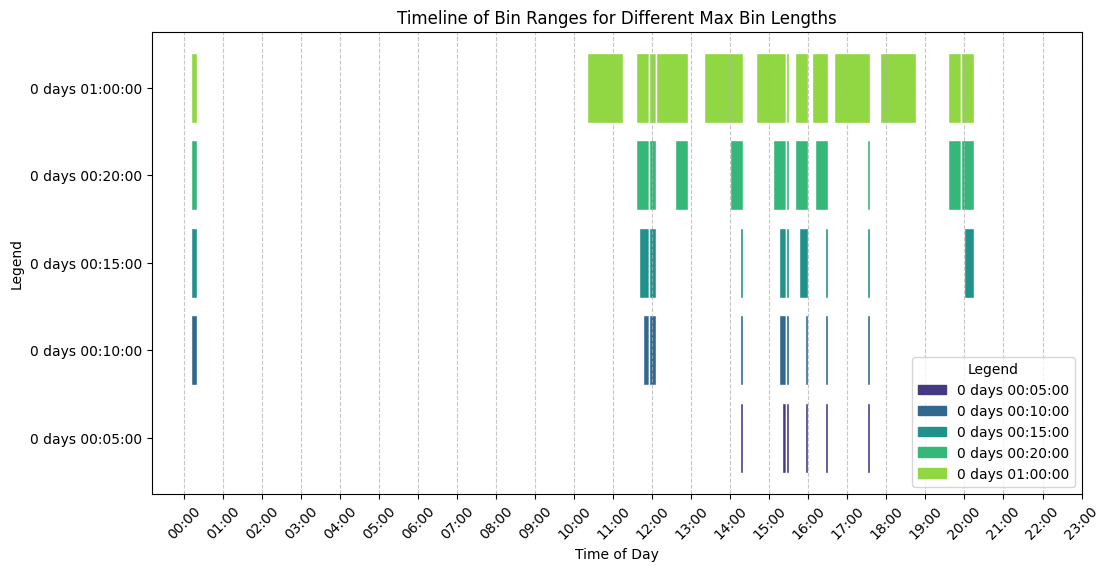

In [8]:
# Assign numeric values for y-axis based on legend
y_labels = df['legend'].unique()
y_mapping = {label: i for i, label in enumerate(y_labels)}
df['y_pos'] = df['legend'].map(y_mapping)

# Define color mapping
palette = sns.color_palette('viridis', n_colors=len(y_labels))
legend_colors = {label: palette[i] for i, label in enumerate(y_labels)}

# Plot timeline graph using broken_barh
fig, ax = plt.subplots(figsize=(12, 6))
for i, row in df.iterrows():
    ax.broken_barh([(row['bin_start'], row['duration'])], (row['y_pos'] - 0.4, 0.8),
                   color=legend_colors[row['legend']], edgecolor='white')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Legend')
ax.set_title('Timeline of Bin Ranges for Different Max Bin Lengths')
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust x-ticks to every 3600 seconds (1 hour)
ax.set_xticks(range(0, 86400, 3600))
ax.set_xticklabels([f"{h:02d}:00" for h in range(24)])
plt.xticks(rotation=45)

# Create legend
handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[label]) for label in y_labels]
ax.legend(handles, y_labels, title='Legend')

plt.show()


In [ ]:
#show the 95% context..
#raph's idea: cut off at 15 minutes, use the starting bin hour.

In [12]:
sql = '''WITH count_5min_bins AS (
SELECT COUNT(*)
FROM gwolofs.congestion_raw_segments_max_bin_analysis
WHERE max_bin = '00:05:00'::interval
)

SELECT max_bin, COUNT(*), COUNT(*) / (SELECT count::numeric FROM count_5min_bins) AS percent_of_original
FROM gwolofs.congestion_raw_segments_max_bin_analysis
GROUP BY max_bin
ORDER BY 1
'''
try:
    with connect(**dbset) as con:
        df = pd.read_sql(sql, con)
        print(df)
except Exception as e:
    print("Error connecting to the database:", e)
    exit()


/tmp/ipykernel_1286164/271536835.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con)


          max_bin    count  percent_of_original
0 0 days 00:05:00  5647506             1.000000
1 0 days 00:10:00  5776554             1.022850
2 0 days 00:15:00  5793370             1.025828
3 0 days 00:20:00  5801453             1.027259
4 0 days 01:00:00  5813682             1.029425


In [ ]:
This shows 15 minutes -> 1 hour max bin only results in 0.3% more observations.

In [2]:
#query to identify which segments have a big discrepency.
sql = '''WITH bins AS (
    SELECT
        CASE
            WHEN time_grp = '[00:00:00,24:00:00)' THEN '24hr'
            WHEN (upper(time_grp) - lower(time_grp)) = '01:00:00'::interval THEN '1hr'
            ELSE 'Periods'
        END AS legend,
        bin_range,
        segment_id,
        dt,
        lower(bin_range) AS bin_start,
        upper(bin_range) AS bin_end
    FROM gwolofs.congestion_raw_segments
    WHERE dt >= '2024-12-01' AND dt < '2024-12-02'
    ORDER BY 1, 2
),

overlap AS (
    SELECT
        segment_id,
        bin_range,
        dt,
        COUNT(*) FILTER (WHERE legend = '24hr') AS count_24hr,
        COUNT(*) FILTER (WHERE legend = '1hr') AS count_1hr,
        COUNT(*) FILTER (WHERE legend = 'Periods') AS count_period
    FROM bins
    GROUP BY 1, 2, 3
)

SELECT
    segment_id,
    dt,
    COUNT(*) FILTER (WHERE count_24hr = 1 AND count_1hr = 1) / SUM(count_24hr) AS overlap_24hr_1_hr,
    COUNT(*) FILTER (WHERE count_24hr = 1 AND count_period = 1) / SUM(count_24hr) AS overlap_24hr_period
FROM overlap
GROUP BY segment_id, dt
ORDER BY 3'''

try:
    with connect(**dbset) as con:
        df = pd.read_sql(sql, con)
        df.head
except Exception as e:
    print("Error connecting to the database:", e)
    exit()



/tmp/ipykernel_1286164/2162353716.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con)


In [9]:
sql = '''
SELECT ROUND(tt, 0) AS tt, COUNT(*)
FROM gwolofs.congestion_raw_segments_max_bin_analysis
WHERE max_bin = '00:15:00'::interval
GROUP BY 1
ORDER BY 1
'''

try:
    with connect(**dbset) as con:
        df = pd.read_sql(sql, con)
except Exception as e:
    print("Error connecting to the database:", e)
    exit()

/tmp/ipykernel_2029777/1152226507.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con)


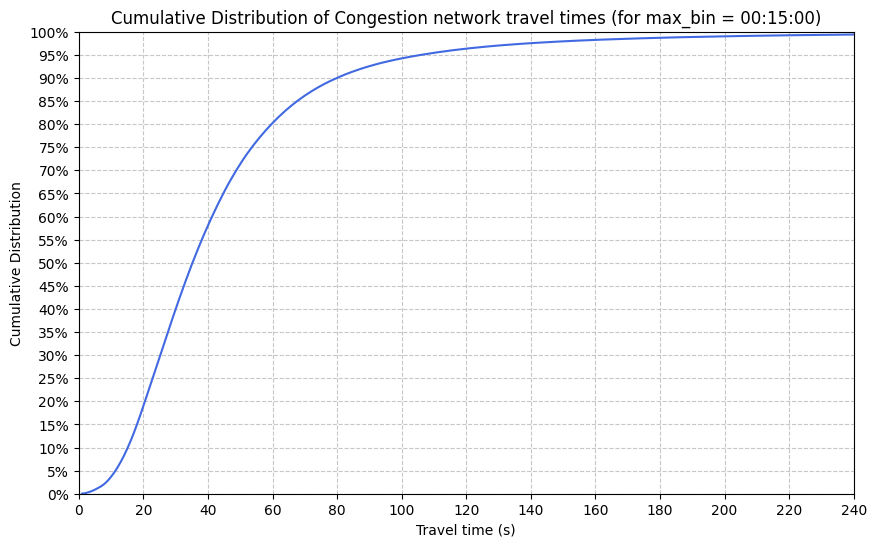

In [11]:
# Compute cumulative distribution
df = df.sort_values(by='tt')
df['cumulative'] = df['count'].cumsum() / df['count'].sum()

# Plot cumulative distribution
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['tt'], y=df['cumulative'], color='royalblue')

plt.xlabel('Travel time (s)')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Congestion network travel times (for max_bin = ''00:15:00'')')
plt.xticks(np.arange(0, 241, 20))  # X-axis limits from 0 to 240
plt.yticks(np.arange(0, 1.05, 0.05), [f'{int(y*100)}%' for y in np.arange(0, 1.05, 0.05)])  # Y-axis every 5%
plt.xlim(0, 240)
plt.ylim(0, 1)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.show()

In [30]:
def make_map(data, basemap_b, centreline_b, highway_b, color, title):
    f, ax = plt.subplots(figsize=(20,20))
    if basemap_b == True:
        basemap.plot(ax=ax, color = 'grey', alpha=0.2)
    if centreline_b == True:
        centreline.plot(ax=ax, color = 'white', alpha=0.2)
    if highway_b == True:
        highway.plot(ax=ax, color = 'white', alpha=0.2)    
    
    data.plot(column = 'id', ax=ax, cmap=color)
    NUM_COLORS = len(data.col.unique())
    cm = plt.get_cmap(color)
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    handles, labels = [], []

    legend_id = data.col.unique()
    for i in range(0, NUM_COLORS):
        label_name = legend_id[i]
        handles.append(mpl.patches.Patch(color=colors[i],label=label_name))
    ax.legend(handles=handles,loc='lower right', ncol=1, title = title)    
    ax.set_axis_off()